# Using the AnalyzeTimeSeries Class

This class contains a set of methods to create a database of data associated with KPF observations, as well as methods to ingest data, query the database, print data, and made time series plots.  An elaborate set of standard time series plots can be made over intervals of days/months/years/decades spanning a date range.  A related script 'ingest_kpf_ts_db.py' can be used to ingest data from the command line.
        
The ingested data comes from L0/2D/L1/L2 keywords, the TELEMETRY extension in L0 files, and the RV extension in L2 files.  With the current version of this code, all TELEMETRY keywords are added to the database and a small subset of the L0/2D/L1/L2 keywords are added. These lists can be expanded, but will require re-ingesting the data (which takes about half a day for all KPF observations).

The first step is importing packages.

In [1]:
from modules.quicklook.src.analyze_time_series import AnalyzeTimeSeries
import pandas as pd
import matplotlib.pyplot as plt
import os
import copy
import numpy as np
import time
import subprocess
import matplotlib.dates as mdates
from datetime import datetime
from astropy.table import Table
%matplotlib inline

## Database Ingestion

The AnalyzeTimeSeries class uses an sqlite3 database stored in a file.  It is is initiated as shown below.  As you can see, the database is fresh because the file `kpf_ts.db` didn't exist. 

In [2]:
db_path = 'kpf_ts.db' # name of database file
myTS = AnalyzeTimeSeries(db_path=db_path)

INFO: Starting AnalyzeTimeSeries
INFO: Jupyter Notebook environment detected.
INFO: Path of database file: /code/KPF-Pipeline/docs/source/tutorials/kpf_ts.db
INFO: Base data directory: /data/L0
INFO: Summary: 14619 obs x 1171 cols over 30 days in 20240401-20240430; updated 2025-01-05 10:31:11


Drop the table if needed.  This is needed if the database scheme were updated since it was last run.

In [3]:
#myTS.drop_table()
myTS = AnalyzeTimeSeries(db_path=db_path)

INFO: Starting AnalyzeTimeSeries
INFO: Jupyter Notebook environment detected.
INFO: Path of database file: /code/KPF-Pipeline/docs/source/tutorials/kpf_ts.db
INFO: Base data directory: /data/L0
INFO: Summary: 14619 obs x 1171 cols over 30 days in 20240401-20240430; updated 2025-01-05 10:31:11


Data can be ingested into the database using several methods.  The first method is one observation at a time.

In [4]:
myTS.ingest_one_observation('/data/L0/20240405/','KP.20240405.86108.92.fits')
myTS.print_db_status()

INFO: Summary: 14619 obs x 1171 cols over 30 days in 20240401-20240430; updated 2025-01-05 10:31:11


Second, one can ingest over a range of dates.  This command will take a few minutes to run, but rerunning it will only take a few seconds once the observations are ingested into the database.

In [5]:
start_date = '20240401'
end_date   = '20240430'
myTS = AnalyzeTimeSeries(db_path=db_path)
#myTS.ingest_dates_to_db(start_date, end_date)
myTS.print_db_status()

INFO: Starting AnalyzeTimeSeries
INFO: Jupyter Notebook environment detected.
INFO: Path of database file: /code/KPF-Pipeline/docs/source/tutorials/kpf_ts.db
INFO: Base data directory: /data/L0
INFO: Summary: 14619 obs x 1171 cols over 30 days in 20240401-20240430; updated 2025-01-05 10:31:11
INFO: Summary: 14619 obs x 1171 cols over 30 days in 20240401-20240430; updated 2025-01-05 10:31:11


The other ingestion methods (not shown) include ingesting based on the ObsIDs from a file (the `add_ObsID_list_to_db()` method) and using the commandline scripts `KPF-Pipeline/scripts/ingest_dates_kpf_tsdb.py` and `KPF-Pipeline/scripts/ingest_watch_kpf_tsdb.py`.

## Database Querying and Display

The database can be queried and displayed.

In [6]:
myTS = AnalyzeTimeSeries(db_path=db_path)
columns_to_display = ['ObsID', 'OBJECT', 'DATE-MID', 'DRPTAG']
myTS.display_dataframe_from_db(columns_to_display)

INFO: Starting AnalyzeTimeSeries
INFO: Jupyter Notebook environment detected.
INFO: Path of database file: /code/KPF-Pipeline/docs/source/tutorials/kpf_ts.db
INFO: Base data directory: /data/L0
INFO: Summary: 14619 obs x 1171 cols over 30 days in 20240401-20240430; updated 2025-01-05 10:31:11
                      ObsID            OBJECT                 DATE-MID  DRPTAG
0      KP.20240405.86108.92  autocal-flat-all  2024-04-05T23:55:23.934  v2.8.2
1      KP.20240401.11539.63   autocal-thar-hk  2024-04-01T03:12:49.663  v2.8.2
2      KP.20240401.07389.18      autocal-bias  2024-04-01T02:03:09.185  v2.8.2
3      KP.20240401.11431.07   autocal-thar-hk  2024-04-01T03:11:01.081  v2.8.2
4      KP.20240401.07439.02      autocal-bias  2024-04-01T02:03:59.076  v2.8.2
...                     ...               ...                      ...     ...
14614  KP.20240430.86051.64  autocal-flat-all  2024-04-30T23:54:26.648  v2.8.2
14615  KP.20240430.86130.13  autocal-flat-all  2024-04-30T23:55:45.166  v2

Or converted into a Pandas dataframe for manipulation or for making custom plots.

In [7]:
df = myTS.dataframe_from_db(columns_to_display)

## Plotting Dictionaries and YAML Files

The AnalyzeTimeSeries has a built-in plotting library that uses dictionaries to pass information.  Here's and example.  Note that `start_date` and `end_date` are formatted as datetime objects, not strings as above.

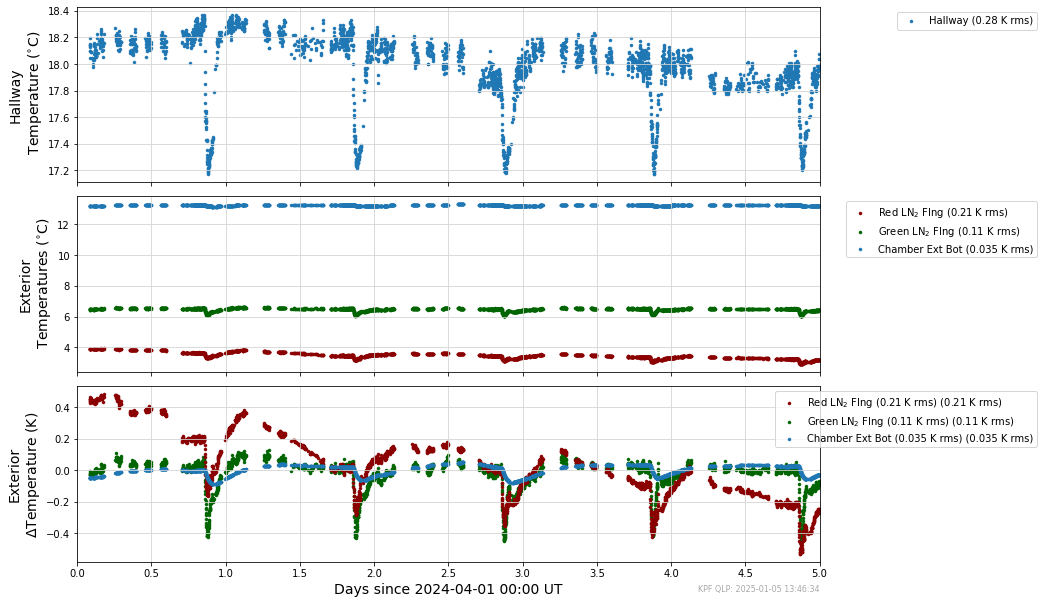

In [8]:
start_date = datetime(2024, 4,  1)
end_date   = datetime(2024, 4,  6)
dict1 = {'col': 'kpfmet.TEMP',              'plot_type': 'scatter', 'unit': 'K', 'plot_attr': {'label':  'Hallway',              'marker': '.', 'linewidth': 0.5}}
dict2 = {'col': 'kpfmet.GREEN_LN2_FLANGE',  'plot_type': 'scatter', 'unit': 'K', 'plot_attr': {'label': r'Green LN$_2$ Flng',    'marker': '.', 'linewidth': 0.5, 'color': 'darkgreen'}}
dict3 = {'col': 'kpfmet.RED_LN2_FLANGE',    'plot_type': 'scatter', 'unit': 'K', 'plot_attr': {'label': r'Red LN$_2$ Flng',      'marker': '.', 'linewidth': 0.5, 'color': 'darkred'}}
dict4 = {'col': 'kpfmet.CHAMBER_EXT_BOTTOM','plot_type': 'scatter', 'unit': 'K', 'plot_attr': {'label': r'Chamber Ext Bot',      'marker': '.', 'linewidth': 0.5}}
dict5 = {'col': 'kpfmet.CHAMBER_EXT_TOP',   'plot_type': 'plot',    'unit': 'K', 'plot_attr': {'label': r'Chamber Exterior Top', 'marker': '.', 'linewidth': 0.5}}
thispanelvars = [dict1]
thispaneldict = {'ylabel': 'Hallway\n' + r' Temperature ($^{\circ}$C)',
                 'legend_frac_size': 0.3}
halltemppanel = {'panelvars': thispanelvars,
                 'paneldict': thispaneldict}

thispanelvars2 = [dict2, dict3, dict4]
thispaneldict2 = {'ylabel': 'Exterior\n' + r' Temperatures ($^{\circ}$C)',
                 'legend_frac_size': 0.3}
halltemppanel2 = {'panelvars': thispanelvars2,
                  'paneldict': thispaneldict2}

thispanelvars3 = [dict2, dict3, dict4]
thispaneldict3 = {'ylabel': 'Exterior\n' + r'$\Delta$Temperature (K)',
                 'subtractmedian': 'true',
                 'legend_frac_size': 0.3}
halltemppanel3 = {'panelvars': thispanelvars3,
                  'paneldict': thispaneldict3}

panel_arr = [halltemppanel, halltemppanel2, halltemppanel3]

plotdict = {
             "description": "Etalon RVs (autocal)",
             "plot_type": "time_series_multipanel",
             "panel_arr": panel_arr
            }
myTS.plot_time_series_multipanel(plotdict, start_date=start_date, end_date=end_date, show_plot=True, clean=True)

The method `plot_time_series_multipanel()` above was written originally for use with dictionaries as shown above.  However, it became easier to the plotting configuration in YAML files and convert to Python dictionaries when reading the configuration.  An example of a configuration file is shown below.

In [9]:
!cat /code/KPF-Pipeline/static/tsdb_plot_configs/QC/qc_lfc.yaml

description: QC - LFC Metrics
plot_type: time_series_multipanel
panel_arr:
  - panelvars:
      - col: LFCSAT
        plot_type: state
        plot_attr:
          label: LFC Not Saturated
          marker: .
    paneldict:
      ylabel: LFC Not Saturated
      title: QC - LFC Metrics
      legend_frac_size: 0.10


This simple example is equivalent to the dictionary `plotdict` below.

In [10]:
dict1 = {'col': 'MONOTWLS', 
         'plot_type': 'state', 
         'plot_attr': {'label':'Montonic WLS','marker': '.'}}
thispanelvars = [dict1]
thispaneldict = {'ylabel': 'Montonic WLS',
                 'title': 'QC - Monotonic WLS in L1',
                 'legend_frac_size': 0.10}

lfcpanel = {'panelvars': thispanelvars,
            'paneldict': thispaneldict}

panel_arr = [lfcpanel]
mydict = {
    "description": "QC - Monotonic WLS in L1",
    "plot_type": "time_series_multipanel",
    "panel_arr": panel_arr
}

In [11]:
myyaml = '''description: QC - Monotonic WLS in L1
plot_type: time_series_multipanel
panel_arr:
  - panelvars:
      - col: MONOTWLS
        plot_type: state
        plot_attr:
          label: Montonic WLS
          marker: .
    paneldict:
      ylabel: Monotonic WLS
      title: QC - Monotonic WLS in L1
      legend_frac_size: 0.10
'''

Below are plots of the dictionary and yaml representations.

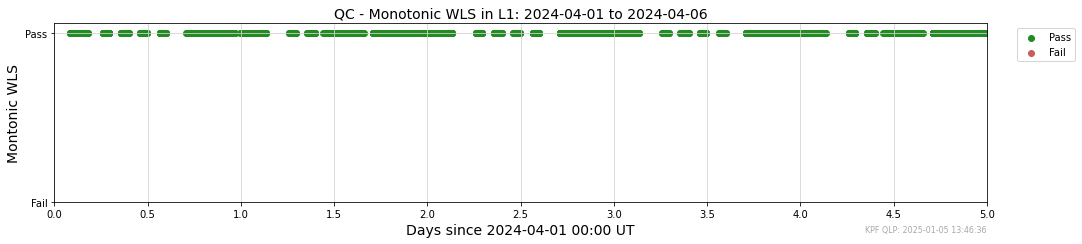

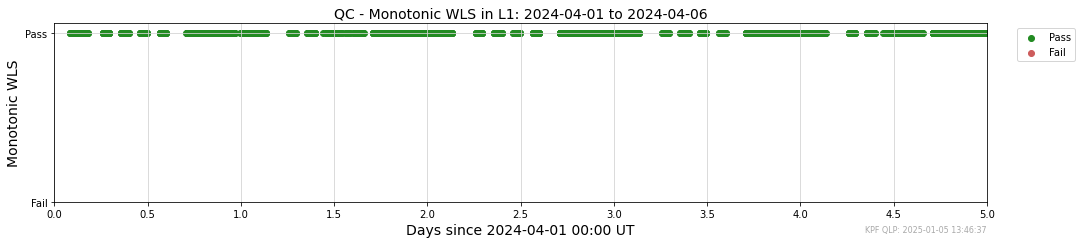

In [12]:
start_date = datetime(2024, 4,  1)
end_date   = datetime(2024, 4,  6)

# Dictionary version
myTS.plot_time_series_multipanel(mydict, start_date=start_date, end_date=end_date, show_plot=True, clean=True)

# YAML version
myyaml_converted = myTS.yaml_to_dict(myyaml)
myTS.plot_time_series_multipanel(myyaml_converted, start_date=start_date, end_date=end_date, show_plot=True, clean=True)

There are also a number of built-in standard plots where the dictionaries above are stored in `plot_standard_time_series()`.  Full set of standard plots is listed below.

In [13]:
myTS.plot_all_quicklook(print_plot_names=True)

Plots available:
    'ccd_controller': CCD Controllers
    'ccd_dark_current': CCD Dark Current
    'ccd_readnoise': CCD Read Noise
    'ccd_readspeed': CCD Read Speed
    'ccd_temp': CCD temperatures
    'chamber_temp': KPF Spectrometer Temperatures
    'chamber_temp_detail': Chamber Temperature Detail
    'hallway_temp': KPF Hallway Temperature
    'fiber_temp': Fiber Temperatures
    'junk_status': Junk Status
    'qc_data_keywords_present': QC - L0 Data and Keywords Present
    'qc_em': QC - Exposure Meter
    'qc_goodread': QC - Good Read Metric
    'qc_lfc': QC - LFC Metrics
    'qc_low_flux': QC - Low Dark and Bias Flux
    'qc_monotonic_wls': QC - Monotonic WLS in L1
    'qc_pos_2d_snr': QC - Not Negative 2D SNR
    'qc_time_check': QC - L0 and L2 Times Consistent
    'socal_snr': SoCal SNR & Flux Ratio
    'autocal_rv': LFC, ThAr, & Etalon RVs (autocal)
    'socal_rv': SoCal RVs
    'autocal_etalon_rv': Etalon RVs (autocal)
    'agitator': KPF Agitator
    'hk_temp': Ca H&K Sp

## Plotting Telemetry
Examples of two built-in standard telemetry plots are shown below.

In [ ]:
start_date = datetime(2024, 4, 1)
end_date   = datetime(2024, 4, 6)
myTS.plot_time_series_multipanel('chamber_temp_detail', start_date=start_date, end_date=end_date, show_plot=True, clean=True)

INFO: Plotting from config: /code/KPF-Pipeline/static/tsdb_plot_configs/Chamber/chamber_temp_detail.yaml


In [ ]:
myTS.plot_time_series_multipanel('ccd_temp', start_date=start_date, end_date=end_date, show_plot=True, clean=True)

The examples above are all plots of float-type variables (e.g., temperatures) over time.  The two below sho examples of state variables changing over time (the DRP version number used to process the data and the result of a quality control test).

In [ ]:
myTS.plot_time_series_multipanel('drptag', start_date=start_date, end_date=end_date, show_plot=True, clean=True)

In [ ]:
myTS.plot_time_series_multipanel('qc_monotonic_wls', start_date=start_date, end_date=end_date, show_plot=True, clean=True)

## Plotting RVs

An example of plotting RVs (instead of telemetry) is shown below.

In [ ]:
myTS.plot_time_series_multipanel('autocal_etalon_rv', start_date=start_date, end_date=end_date, show_plot=True, clean=True)

Here's an example of plotting SoCal RV and spectral SNR time series.

In [ ]:
start_date = datetime(2024, 4, 4)
end_date   = datetime(2024, 4, 5)
myTS.plot_time_series_multipanel('socal_rv',  start_date=start_date, end_date=end_date, show_plot=True, clean=True)
myTS.plot_time_series_multipanel('socal_snr', start_date=start_date, end_date=end_date, show_plot=True, clean=True)    

One can also plot information about on-sky conditions.

In [ ]:
start_date = datetime(2024, 4, 2)
end_date   = datetime(2024, 4, 3)
myTS.plot_time_series_multipanel('seeing',   start_date=start_date, end_date=end_date, show_plot=True, clean=True)
myTS.plot_time_series_multipanel('sun_moon', start_date=start_date, end_date=end_date, show_plot=True, clean=True)    

One can also generate all plots from the `plot_all_quicklook_daterange()` method with a single call.  The line below is commented out because it generates a large number of plots (a few dozen) that are too much output for this tutorial.  Change `if False:` to `if True:` in the line below in your own notebook to generate the output.

In [ ]:
if True:
    myTS = AnalyzeTimeSeries(db_path=db_path)
    myTS.plot_all_quicklook(datetime(2024, 4, 1), interval='day', show_plot=True, verbose=True)

## Making Histograms of Observations Over Time

Make a plot of the number of observations for the whole time span that's been ingested.

In [ ]:
myTS.plot_nobs_histogram(interval='year', date='20240402', show_plot=True, plot_source=True)

Show the observations by type for the that month and one day.

In [ ]:
myTS.plot_nobs_histogram(interval='month', date='20240402', plot_source=True, show_plot=True)

In [ ]:
myTS.plot_nobs_histogram(interval='day', date='20240402', plot_source=True, show_plot=True)

Show the number of observations of just one source over a month.

In [ ]:
myTS.plot_nobs_histogram(interval='month', date='20240402', plot_source=True, show_plot=True, only_sources=['Flat'])

Show the number of stell observations per UT night.

In [ ]:
myTS.plot_nobs_histogram(interval='month', date='20240402', plot_source=True, show_plot=True, only_sources=['Star'])